# Training a 2D Unet model

In this model, we will demonstrate how to train a U-Net model from scratch. It is strongly encouraged to create a separate environment for this:

```
conda create -n pytorch-segmentation python=3.9
conda activate pytorch-segmentation
```
In order to correctly install pytorch, find the matching command for your system on the [pytorch page](https://pytorch.org/get-started/locally/):

![](./torch_get_started.png)

After that is done, install some more packages:

```
mamba install scikit-image albumentations segmentation-models-pytorch pandas matplotlib torchmetrics tensorboard -c conda-forge
```



In [1]:
import os
import numpy as np
import tqdm
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import yaml

import albumentations as albu
import torch, torchmetrics
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.utils.tensorboard import SummaryWriter

import segmentation_models_pytorch as smp
import requests
import zipfile

C:\Users\johan\Anaconda3\envs\pytorch-segmentation\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset preparation

The first thing we have to do for Pytorch training, is tpo create a custom `Dataset` class for our dataset. This dataset object will then serve as a utility through which Pytorch can access and load all the data from the drive. During the training process we will iterate over our dataset, so the `Dataset` implementation needs to have two important member functions:

* `__len__()`: The Dataloader needs to know how *many* samples there are.
* `__getitem__()`: The Dataloader needs to be able to access the i-th sample out of our whole dataset.

In this example, we will create a pandas dataframe with two columns `image` and `mask` and pass this to the Dataset. Working with dataframes is particularly easy because it allows us to easily split our data into a training and a validation cohort.

*Note 1*: We will add the option for augmentation to the datafly. If we pass an augmentation function as an argument (which should accept parameters `image` and `mask` as inputs), the augmentations are applied on-the-fly. We will use the [albumentations package](https://albumentations.ai/) for this.
*Note 2*: We will use a pretrained model. Such pretrained models are typically implemented for "normal" images, i.e. RGB images. Hence, the used model expects images to have the dimensions `[3, Y, X]`. Thus, if we work with grayscale images, we need to stack the single channel we are working with 3 times to create an artifical RGB image.

In [2]:
class Dataset():
    def __init__(self, root, image_dir = 'images', labels_dir = 'labels', augmentation=None):
        self.root = root
        self.augmentation = augmentation
        
        self.image_dir = os.path.join(root, image_dir)
        self.labels_dir = os.path.join(root, labels_dir)
        
        images = os.listdir(os.path.join(self.root, image_dir))
        labels = os.listdir(os.path.join(self.root, labels_dir))
        
        self.data = pd.DataFrame(np.asarray([images, labels]).T, columns=['images', 'labels'])

    def __getitem__(self, i):
        filename_image = os.path.join(self.image_dir, self.data['images'].loc[i])
        filename_label = os.path.join(self.labels_dir, self.data['labels'].loc[i])
        image = io.imread(filename_image)/255
        mask = np.argmax(io.imread(filename_label), axis=2)

        if self.augmentation:
            sample = self.augmentation(image=image.astype(np.float32), mask=mask)
            image, mask= sample['image'], sample['mask']

        return {'image': image.astype(float).transpose((2,0,1)), 'labels' : mask[None, :]}


    def __len__(self):
        return len(self.data)

Download the data:

In [3]:
if not 'data.zip' in os.listdir('.'):
    r = requests.get(r'https://zenodo.org/record/7213527/files/HE_segmentation_data.zip')
    with open("data.zip", 'wb') as f:
        f.write(r.content)
        
    with zipfile.ZipFile('./data.zip', 'r') as zip_ref:
        zip_ref.extractall('./data')

Unzip:

In [4]:
root = os.path.abspath('./data')
root

'E:\\BiAPoL\\Projects\\Quantitative_Bio_Image_Analysis_with_Python_2022\\docs\\day2e_deep_learning_segmentation\\data'

Let's use this opportunity to quickly check what the above-defined Dataset class does with this. For thhis, we create an instance of the Dataset class using the dataframe with the filenames of our training data. Then we'll try to get an arbitrary sample from the dataset:

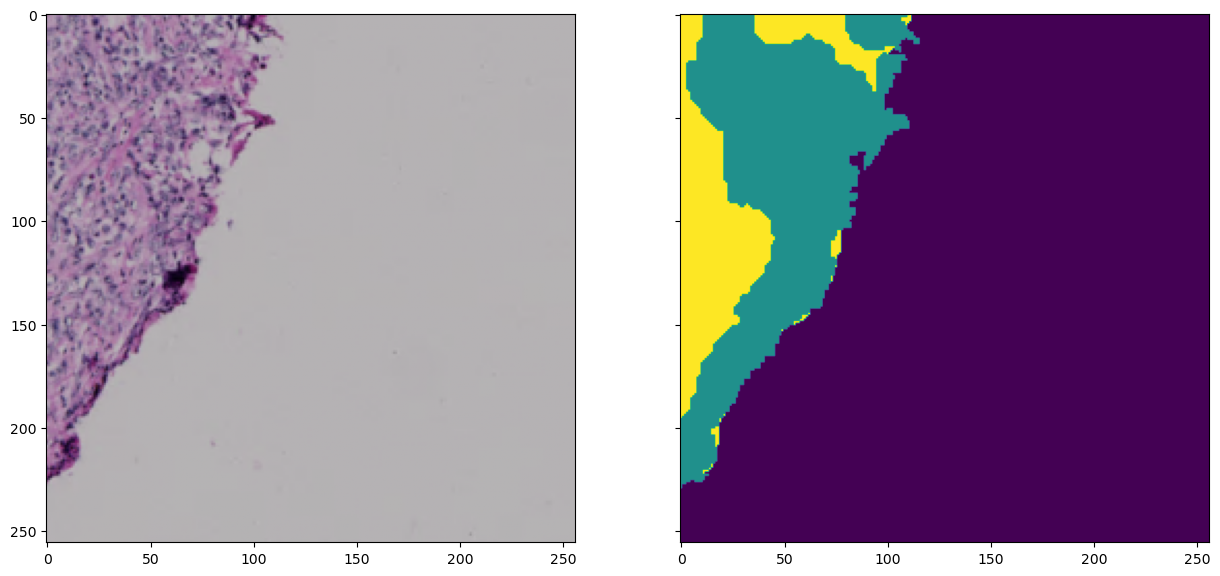

In [5]:
MyDataset = Dataset(root=os.path.join(root, 'train'))
sample = MyDataset[1]

fig, axes = plt.subplots(ncols=2, figsize=(15, 15), sharex=True, sharey=True)
axes[0].imshow(sample['image'].transpose((1,2,0)))
axes[1].imshow(sample['labels'][0])

## Augmentation

For a typical segmentation job, it makes sense to augment the data to a certain degree. Albumentations allows to compose several augmentations together and luckily apply it to the image and the mask alike on-the fly. We will use the following augmentations for the training:
* Vertical flip: Flip the image upside down in 50% of all calls
* Horizontal flip: Same, but horizontal
* Random Rotate: * Randomly rotate image and mask by 90 degrees in 50% of all calls
* Random brightness/contrast: randomly change the brightness/contrast setting of the image in 20% of all calls

In [6]:
aug_train = albu.Compose([
    albu.VerticalFlip(p=0.5),
    albu.HorizontalFlip(p=0.5),
    albu.RandomRotate90(p=0.5),
    albu.RandomBrightnessContrast(p=0.2)
])

### Train/test/validation split

Last but not least, we need to create three subsets from our dataset, a training-, test- and validation-cohort. In every epoch of training (see below), the training process will look at all images in the training cohort and update our model based on this. The model is then applied to the images in the test cohort without updating the model. This is to see how well the method is currently performing. Finally, the model is appliedto the image data in the validation cohort to measure its performance on unknown data.  Scikit-learn provides the KFold strategy for problems like this.

In [7]:
ds_train = Dataset(os.path.join(root, 'train'), augmentation=aug_train)
ds_test = Dataset(os.path.join(root, 'test'))
ds_valid = Dataset(os.path.join(root, 'validation'))

In [8]:
print('Samples in training set: ', len(ds_train))
print('Samples in testing set: ', len(ds_test))
print('Samples in validation set: ', len(ds_valid))

Samples in training set:  503
Samples in testing set:  126
Samples in validation set:  70


## Model creation and preparation

Next, we have to actually create an instance of a model which we will train for a number of epochs. This section will mostly set some parameters which are explained here.

* `device`: GPU or CPU? torch works only on Cuda-capable cards. To enable GPU-training, set this variable to `cuda`. Otherwise set it to `cpu`
* `n_classes`: As desribed elsewhere, we are only trying to separate a background nd a foreground here. Hence, there are only 2 classes in our case.
* `epochs`: In one epoch, the the Dataloader will go throough the entire dataset, update the layers and then check the net's performance in the test dataset. This is then repeated `epochs` times
* `batch_size`: During the training process, multiple images are stitched together to a batch of images. This is done along a batch axis that is added to the image data. Typically, images are provided in  `[B, C, Y, X]` shape, with `B` being the batch dimension, `C` the channel dimension and `Y, X` being the actual image dimensions. If the `batch_size` is set too large, the images may not fit on the GPU anymore. 
*Note*: Images in a batch are usually batch-averaged! In other words, the pixel intensity values will be z-score normalized using the commmon mean and standard deviation of the entire batch. Making the batch too small can disrupt these running statistics.

* `learning_rate`: How much the weights of every layer should be changed  in every training step. This is also referred to as the momentum of the training - see [here](https://twitter.com/marktenenholtz/status/1490309316347248646) for a nice explanation!
* `num_workers`: How many CPU cores are allowed to be used to operate the dataloaders to feed the data to the network

In [11]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

n_classes = 3
epochs = 130
batch_size = 6
learning_rate = 2e-5
num_workers = 0
tile_size = ds_train[0]['image'].shape[-1]  # get from dataset

In [21]:
model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    classes=n_classes,
    activation=None,
)

model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

At the end of the day, deep learning is a tricky optimization job. torch provides a few optimizers:

In [13]:
# Specify optimizer & early stopping
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

## The loss

An aspect of paramount importance is the used **loss function**. After all, deep learning is all about passing data through the network, evaluating the performance and then changing the weights accordingly. The loss function determines how exactlly performance is measured. Torch offers a few different implementations but you can basically implement any metric that compares two label images and calculates something like a degree of similarity. Something that is very commonly used (and thus being used here) is the `CrossEntropyLoss()` function, which calculates the cross-entropy of two label images. The [CrossEntropy ](https://en.wikipedia.org/wiki/Cross_entropy) is closely related to the [Mutual Information](https://en.wikipedia.org/wiki/Cross_entropy).

Since the cross-entropy is a bit abstract to interpret, we will use a more intuitive measure to monitor the performance of our network in the validation cohort: The [Jaccard-coefficient](https://en.wikipedia.org/wiki/Jaccard_index). During the training we should observe that the cross-entropy in the training process goes down while the Jaccard-index should converge closer to 1.

In [14]:
criterion_train = CrossEntropyLoss()
criterion_test = torchmetrics.functional.accuracy

### Training

Now we have everything at hand to actually start training! For this, we first create Datasets from our train/test dataframes. Let's not forget to pass the composed albumentations **only to the training dataset.** We could also apply the augmentations to the trainign data, but it is preferable to have performance statistics on the real, unchanged image data.

In [15]:

# Create dataloaders
train_dataloader = DataLoader(dataset=ds_train, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(dataset=ds_test, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(dataset=ds_valid, batch_size=batch_size, num_workers=num_workers)

Every training epoch follows the following steps:

* Set the model to training mode: In this mode, torch automatically updates the gradients of the model's layers on-the-fly as image data is passed through the layers. The optimizer can then have a look at these gradients to know how the convolutions in the respective layers need to be changed to improve performance
* Reset the gradients known to the optimizer from the previous epoch
* Pass each batch of training data through the network and calculate the loss (deviation of acquired result and correct mask)
* Back-propagate the loss through the network and calculate the gradients
* Let the optimizer update the weights of the network

To check the progress of the training, navigate to the working directory in a terminal and open the tensorboard with

```
tensorboard --logdir=runs
```

Then, navigate to http://localhost:6006/ in the browser.

In [18]:
writer = SummaryWriter()

In [ ]:
best_score = 0

for epoch in range(epochs):
    model.train()  # set to training mode
    optimizer.zero_grad()  # reset gradients
    tk0 = tqdm.tqdm(train_dataloader, total=len(train_dataloader), desc='Epoch: ' + f'{epoch}')
    
    avg_train_loss = []
    for b_idx, data in enumerate(tk0):
        
        # Move images and masks in batch to GPU
        for key, value in data.items():
            data[key] = value.to(device).float()
            
        # Feed the batch through the network and catch output into a new dictionary key
        data['prediction']  = model(data['image'])
        
        # Calculate and track the loss
        loss = criterion_train(data['prediction'], data['labels'].squeeze().long())
        avg_train_loss.append(loss.cpu().detach().numpy())
        
        # Update the weights
        loss.backward()
        optimizer.step()
    writer.add_scalar('Loss/train', np.asarray(avg_train_loss).squeeze().mean(), epoch)
        
    # Switch to validation: No updating gradients now.
    model.eval()
    avg_test_loss = []
    with torch.no_grad():
        tk1 = tqdm.tqdm(test_dataloader, total=len(test_dataloader))
        
        for b_idx, data in enumerate(tk1):
            
            # Move only images to GPU and directly pass the batch through the model
            data['prediction'] = model(data['image'].to(device).float())
            out = torch.argmax(data['prediction'], dim=1)
            
            test_loss = criterion_test(data['prediction'].argmax(axis=1).cpu(), data['labels'].int(), average=None, num_classes=3)
            avg_test_loss.append(test_loss)
            
        averages=np.mean(np.stack(avg_test_loss), axis=1)        
        writer.add_scalar(f'Loss/test class 0', averages[0], epoch)
        writer.add_scalar(f'Loss/test class 1', averages[1], epoch)
        writer.add_scalar(f'Loss/test class 2', averages[2], epoch)
        
    # if this model is better than the ones before, save it
    if np.mean(averages) > best_score:
        best_score = np.mean(averages)
        torch.save(model.state_dict(), './best_model.pt')
    print('Train loss:', np.asarray(avg_train_loss).squeeze().mean(), 'Test loss: ', np.mean(averages))
    

## Validation

Last but not least, let's apply the trained model to the data in the validation cohort and calculate performance statistics.

In [23]:
valid_score = []
tk2 = tqdm.tqdm(valid_dataloader, total=len(valid_dataloader))

for b_idx, data in enumerate(tk2):
    # Move only images to GPU and directly pass the batch through the model
    data['prediction'] = model(data['image'].to(device).float())
    out = torch.argmax(data['prediction'], dim=1)

    valid_loss = criterion_test(data['prediction'].argmax(axis=1).cpu(), data['labels'].int(), average=None, num_classes=3)
    valid_score.append(valid_loss)

In [28]:
valid_score = np.stack(valid_score).mean(axis=0)
performance = {}
for i in range(n_classes):
    print(f'Accuracy for label {i}: {valid_score[i]}')
    

Accuracy for label 0: 0.9536442160606384
Accuracy for label 1: 0.8054279685020447
Accuracy for label 2: 0.9184861779212952


## Advanced implementation aspects:

There are a few options we can to improve the training process and make it more robust. Some of them are listed here and will be expored in more advanced notebooks for the sake of this notebook's simplicity.

* **Early Stopping:** We have implemented a naive way of stopping the training process if the model is good enough. However, to effectively prevent overfitting, we need to stop the training process as soon as performance is not improving anymore. Thus, a more suitable early stopping implementation would have to look at the train/test performance scores within the last X epochs and check if the variance of performance scores has been small. If so, the training process will be interrupted.
* **Weighted sampling**: If we want to segmented regions in the image, which are rare in our training data, any well-behaving network should lean towards not predicting such labels *at all*. After all, the error in prediction is small if these labels are sufficiently scarce. To counter this, we can introduce [weighted sampling](https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler) to ensure that the network is equally exposed to all present labels in the image data.
* **Scheduling**: As the model converges closer to its optimum, it is not wise to keep updating the model at the same speed as during the first epochs. We can do this by changing the `learning_rate` parameter as we progress through the epochs. Thus, the steps become smaller and safer. See [this tweet](https://twitter.com/marktenenholtz/status/1490309316347248646) for a nice visualization.
* **Visualization**: It is good practice to visualize the training process through a side-by-side comparison of reference annotation and predicted label image.

## Inference

Applying the model to data is also called inference. Let's try this on some sample data. If you have not trained a model of your own previously, you can load the one that comes with the downloaded data:

In [25]:
model.load_state_dict(torch.load('./data/best_model.pt'))

<All keys matched successfully>

Disable gradients:

In [49]:
torch.no_grad()

In [87]:
test_image = io.imread(r'C:\Users\johan\OneDrive\Desktop\HE_seg_training_data\test_data.tif').transpose((2,0,1))
test_image.shape

(3, 2676, 3332)

We need to tile up our data because moving everything through the network at once takes too much memory:

In [94]:
tile_size=512

In [95]:
prediction = np.zeros((n_classes, test_image.shape[1], test_image.shape[2]))
for i in range(test_image.shape[1]//tile_size):
    for j in range(test_image.shape[2]//tile_size):
        tile = test_image[:, i * tile_size:(i+1) * tile_size, j * tile_size:(j+1) * tile_size][None, :]
        tensor = torch.tensor(tile).to(device)
        prediction_tile = model(tensor.float()).detach().cpu().numpy()
        
        prediction[:, i * tile_size:(i+1) * tile_size, j * tile_size:(j+1) * tile_size] = prediction_tile
        
        

In [97]:
fig, axes = plt.subplots(ncols=4)
axes[0].imshow(test_image.squeeze().transpose((1,2,0)))
axes[1].imshow(prediction[0], vmin=0, vmax=1)
axes[2].imshow(prediction[1], vmin=0, vmax=1)
axes[2].imshow(prediction[2], vmin=0, vmax=1)

In [ ]:
with torch.no_grad():
    tk0 = tqdm.tqdm(valid_dataloader, total=len(valid_dataloader))
    for b_idx, data in enumerate(tk0):

        # Move images and masks in batch to GPU
        for key, value in data.items():
            data[key] = value.to(device).float()

        # Feed the batch through the network and catch output into a new dictionary key
        data['prediction']  = model(data['image'])

        for i in range(data['image'].shape[0]):
            fig, axes = plt.subplots(ncols=4, figsize=(10,40))
            axes[0].imshow(data['image'][i].cpu().numpy().transpose((1,2,0)))
            axes[1].imshow(data['prediction'][i][0].cpu().numpy())
            axes[2].imshow(data['prediction'][i][1].cpu().numpy())
            axes[3].imshow(data['prediction'][i][2].cpu().numpy())
            axes[0].set_title('Raw')
            axes[1].set_title('Probbility label 0: Background')
            axes[2].set_title('Probbility label 1: Necrosis')
            axes[3].set_title('Probbility label 2: Vital')
            fig.tight_layout()

In [122]:
torch.save(model.state_dict(), './best_model.pt')